## Проект
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import scipy
from scipy import stats

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [3]:
df_reg = pd.read_csv('C:/Users/Vladimir/Dropbox/Проект/problem1-reg_data.csv', sep = ';')

In [4]:
df_auth = pd.read_csv('C:/Users/Vladimir/Dropbox/Проект/problem1-auth_data.csv', sep = ';')

In [7]:
df_auth.head()

,auth_ts,uid,date_auth
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39


In [8]:
df_reg.head()

,reg_ts,uid,date_reg
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27
3,959523541,4,2000-05-28 14:19:01
4,969103313,5,2000-09-16 11:21:53


In [5]:
def retention(df_reg, df_auth, reg_start, reg_end, count_days = 30):
    """
    Параметры
    -------------
    df_reg: DataFrame
        данные регистрации включающие столбцы 'reg_ts':int, 'uid':int
    df_auth: DataFrame
        данные регистрации включающие столбцы 'auth_ts':int, 'uid':int
    reg_start:string
        пользователи которые зарегистрировались начииная с этой даты "Y%-m%-d%"
    reg_end:string
        пользователи которые зарегистрировались до этой даты "Y%-m%-d%"
    count_days: int
        для скольки дней после регистрации считаем Retention
    """
    # Переводим timestamp в дни
    df_reg['date_reg'] = pd.to_datetime(df_reg['reg_ts'], unit = 's')

    df_auth['date_auth'] = pd.to_datetime(df_auth['auth_ts'], unit = 's')

    # Создаем общий Датафрейм с ключом по айди пользователя
    df = df_auth.merge(df_reg, on = 'uid')

    # Выделяем нужную дату
    df = df[(df.date_reg >= reg_start) & (df.date_reg <= reg_end)]

    df['date_reg'] = df['date_reg'].dt.date

    df['date_auth'] = df['date_auth'].dt.date

    # Вычисляем количество дней после регистрации для  каждой авторизации
    df = df.assign(date_after_reg=lambda x: (x.date_auth - x.date_reg))

    df[['uid','date_reg', 'date_auth', 'date_after_reg']]

    df['date_after_reg'] = df['date_after_reg'].dt.days

    #группируем пользователей по когортам регистрации и дней после регистрации, но не более 30 дней
    df = df[(df.date_after_reg < (count_days + 1))]\
            .groupby(['date_reg', 'date_after_reg'], as_index = False)\
            .agg({'uid' : "nunique"})\
            .rename(columns = {'uid' : 'active_users'})

    # Создаем ДатаФрейм с количеством пользователей в когорте для подсчета Retention
    df_cogort_users = df.query('date_after_reg == 0')\
                        .rename(columns = {'active_users' : 'cogort_users'})\
                        .drop(['date_after_reg'], axis = 1)

    df = df.merge(df_cogort_users, on = 'date_reg')

    # Считаем Retention
    df = df.assign(retention=lambda x: round((x.active_users/x.cogort_users),2))

    # разворачиваем таблицу
    df_pivot = df.pivot(index = 'date_reg', columns = 'date_after_reg', values = 'retention')

    # Визуализация
    plt.figure(figsize=(18, 16))
    plt.title('Retention per day after registration in cogorts')
    sns.heatmap(df_pivot, annot=True, fmt=".0%")

    #Средневзвешеный Retention по дням
    df_avg_weight_retention = df.query('date_after_reg != 0')\
                                .groupby("date_after_reg")\
                                .agg({'active_users' : 'sum'})\
                                .assign(AVG_weight_retention=lambda x: ((x.active_users/df.query('date_after_reg == 0 ').active_users.sum())*100).round(2)) 

    print(df_avg_weight_retention)

                active_users  AVG_weight_retention
date_after_reg                                    
1                        672                  2.06
2                       1337                  4.10
3                       1555                  4.77
4                       1713                  5.25
5                       1842                  5.65
6                       2278                  6.98
7                       1855                  5.69
8                       1566                  4.80
9                       1643                  5.04
10                      1663                  5.10
11                      1639                  5.02
12                      1617                  4.96
13                      1562                  4.79
14                      1444                  4.43
15                      1512                  4.64
16                      1465                  4.49
17                      1404                  4.30
18                      1351   

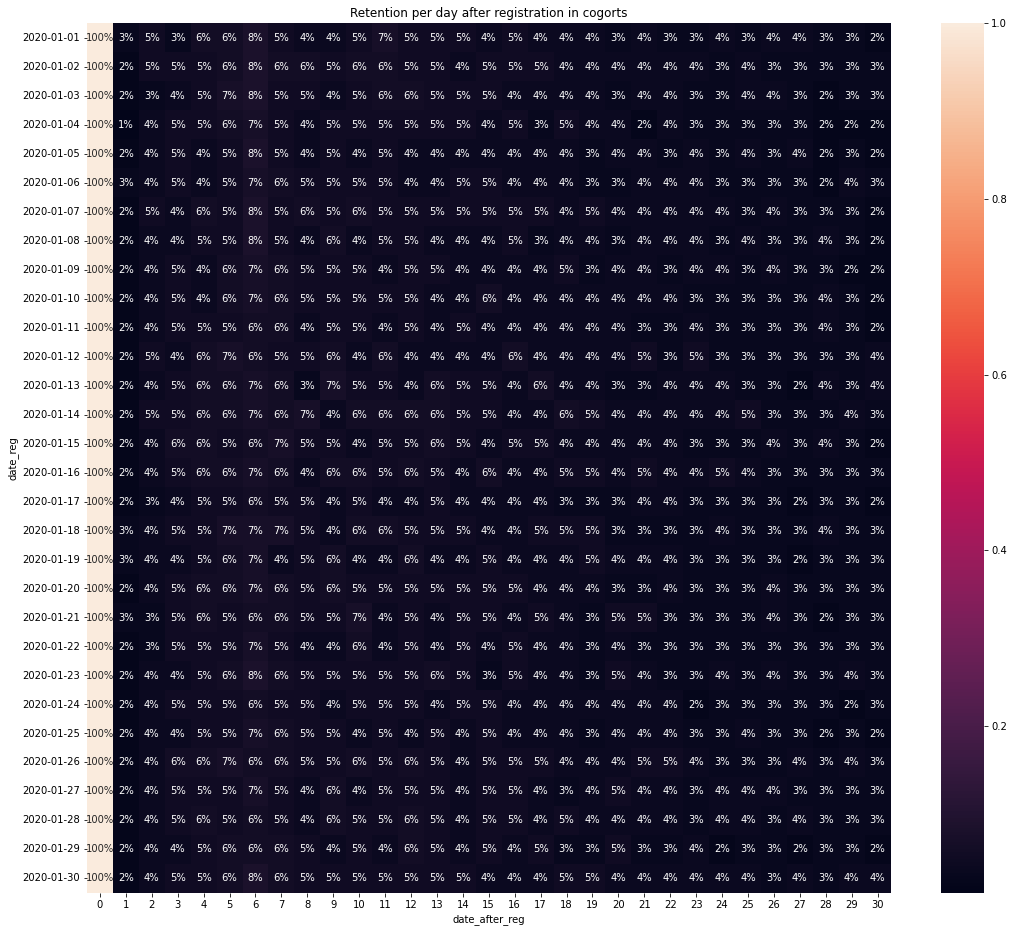

In [6]:
retention(df_reg, df_auth, "2020-01-01", "2020-01-31")

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [9]:
#Загружаем файл
df_ab = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep = ';')

Посмотрим метрики ARPPU, ARPU и конверсию в платящего пользователя в тестовой и контрольной группе

In [10]:
df_ab_arpu = df_ab.groupby('testgroup', as_index = False)\
                    .agg({'user_id' : 'count', 'revenue' : 'sum'})

df_ab_arpu = df_ab_arpu.assign(ARPU = lambda x : (x.revenue / x.user_id)).round(2)
df_ab_arpu

df_ab_arppu = df_ab.query('0 < revenue')\
                    .groupby('testgroup', as_index = False)\
                    .agg({'user_id' : 'count', 'revenue' : 'sum'})
df_ab_arppu = df_ab_arppu.assign(ARPPU = lambda x : (x.revenue / x.user_id)).round(2)
df_ab_arppu

df_ab_metrics = df_ab_arpu.merge(df_ab_arppu, on = "testgroup")\
                            .rename(columns = {'user_id_x' : 'users', 'user_id_y' : 'purchase_users','revenue_x' : 'revenue' })

df_ab_metrics = df_ab_metrics[['testgroup', 'users', 'purchase_users', 'revenue', 'ARPPU', 'ARPU']]

df_ab_metrics.assign(CR = lambda x : (((x.purchase_users/x.users)*100).round(2)))

,testgroup,users,purchase_users,revenue,ARPPU,ARPU,CR
0,a,202103,1928,5136189,2664.00,25.41,0.95
1,b,202667,1805,5421603,3003.66,26.75,0.89


В таблице мы видим, что конверсия в контрольной группе больше ~ 6% 
Более потробно посмотрим на доход с пользователей

In [11]:
df_ab.query('testgroup == "a" and revenue > 0')\
        .sort_values('revenue')\
        .revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [12]:
df_ab.query('testgroup == "b" and revenue > 0')\
        .sort_values('revenue')\
        .revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Видно, что медианы у групп отличаются почти в 10 раз.
Построим граффик распределения дохода по группам

In [13]:
df_ab_purchase = df_ab.query(' 0 < revenue')

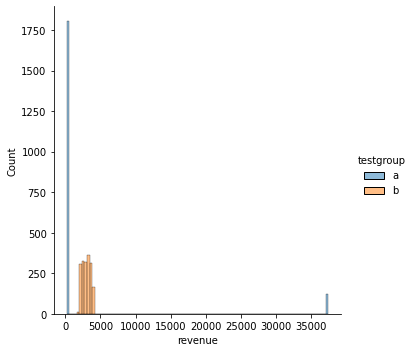

In [14]:
sns.displot (data = df_ab_purchase.dropna(), x = 'revenue', hue = 'testgroup')

Попробуем прологорифмировать распределения

In [15]:
df_ab_purchase['log_revenue'] = np.log(df_ab_purchase.revenue)

C:\Users\Vladimir\AppData\Local\Temp/ipykernel_7680/3308362058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ab_purchase['log_revenue'] = np.log(df_ab_purchase.revenue)


In [16]:
df_ab_purchase

,user_id,revenue,testgroup,log_revenue
72,73,351,a,5.860786
160,161,3797,b,8.241967
341,342,290,a,5.669881
377,378,3768,b,8.234300
385,386,250,a,5.521461
...,...,...,...,...
404315,404316,262,a,5.568345
404525,404526,3120,b,8.045588
404543,404544,369,a,5.910797
404602,404603,251,a,5.525453


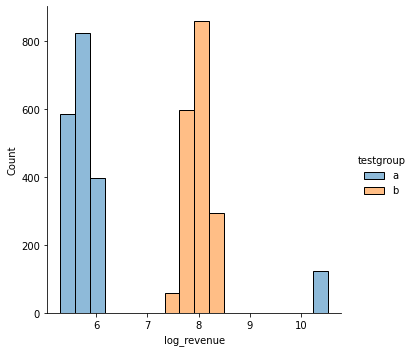

In [17]:
sns.displot (data = df_ab_purchase.dropna(), x = 'log_revenue', hue = 'testgroup')

На граффике видно что в контрольной группе есть выбросы (Высокодоходные пользователи "Киты"). 
Посчитаем их количество

In [18]:
df_ab.query(' 30000 < revenue').user_id.count()

123

 - Основная масса пользователей распределилась равномерно в контрольной и тестовой группе.
 - 123 пользователя в контрольной группе вносят существенный вклад в доход и увеличивают ARPPU и ARPU.
 - Необходимо понять почему они есть в контрольной группе и нету в тестовой.
 - Возможно это техническая ошибка или "Китам" не понравилось акционное предложение в тестовой группе.
 

##### Проверим распределение в группах с помощью теста Шапира Уилка

H0 - у групп нормальное распределение

In [19]:
stats.shapiro(df_ab_purchase.query('testgroup == "a"').revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)

In [20]:
stats.shapiro(df_ab_purchase.query('testgroup == "a" and revenue < 30000').revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.9577841758728027, pvalue=2.1958386833413916e-16)

In [21]:
stats.shapiro(df_ab_purchase.query('testgroup == "b"').revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)

 - Все варианты распределений не нормальны

##### Проверим группы тестом непараметрическим Манн-Уитни

H0 - у групп нет статистически значимых различий

In [22]:
stats.mannwhitneyu(df_ab_purchase.query('testgroup == "a"').revenue, df_ab_purchase.query('testgroup == "b"').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In [23]:
stats.mannwhitneyu(df_ab_purchase.query('testgroup == "a" and revenue < 30000').revenue, df_ab_purchase.query('testgroup == "b"').revenue)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

 Тест показал статистически значимые различия между распределениями. Таким образом, можно утверждать, что метрика ARPPU значимо выросла в тестовой группе по сравнению с контрольной.

Посмотрим метрики ARPPU, ARPU и конверсию в платящего пользователя в тестовой и контрольной группе без учета выброса в контрольной группе

In [24]:
df_ab_arpu = df_ab.groupby('testgroup', as_index = False)\
                    .agg({'user_id' : 'count', 'revenue' : 'sum'})

df_ab_arpu = df_ab_arpu.assign(ARPU = lambda x : (x.revenue / x.user_id)).round(2)
df_ab_arpu

df_ab_arppu = df_ab.query('0 < revenue < 30000')\
                    .groupby('testgroup', as_index = False)\
                    .agg({'user_id' : 'count', 'revenue' : 'sum'})
df_ab_arppu = df_ab_arppu.assign(ARPPU = lambda x : (x.revenue / x.user_id)).round(2)
df_ab_arppu

df_ab_metrics = df_ab_arpu.merge(df_ab_arppu, on = "testgroup")\
                            .rename(columns = {'user_id_x' : 'users', 'user_id_y' : 'purchase_users','revenue_x' : 'revenue' })

df_ab_metrics = df_ab_metrics[['testgroup', 'users', 'purchase_users', 'revenue', 'ARPPU', 'ARPU']]

df_ab_metrics.assign(CR = lambda x : (((x.purchase_users/x.users)*100).round(2)))

,testgroup,users,purchase_users,revenue,ARPPU,ARPU,CR
0,a,202103,1805,5136189,302.46,25.41,0.89
1,b,202667,1805,5421603,3003.66,26.75,0.89


Видим, что без учета выброса в контрольной группе конверсия и количество платящих пользователей равны и ARPPU в тестовой группе ~ в 10 раз больше чем в контрольной группе

### Выоды

 - В тестовой группе распределение revenue равномерное
 - В контрольной группе есть пользователи, которые платят мало и небольшое кол-во пользователей, которые платят очень много
 
 Есть две гипотезы:
- Либо выбросы в контрольной группе это ошибки в данных.
- Либо по какой-то причине сильно платящие клиенты перестали платить так много (мб ошибка какая-то в системе оплаты)
- Поэтому я бы изучил подробнее этих клиентов


- Но даже с наличием выбросов тестовая группа имеет стат.значимые различия поэтому можно считать это предложение лучшим

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


- DAU -  посмотреть увеличиваются ли количество наших пользователей в дни с акциями и после;
- MAU - количество уникальных пользователей, которые зашли в приложение в течение месяца;
- Stickiness rate = DAU / MAU Залипательность 
- CR - по прохождению уровней, по получению наград и успешно прошедших событие;
- Время, которое пользователь тратит на переход на следующий уровень;
- Retention - за время прохождения акции в сравнении до акции;
- Средняя продолжительность сессии (average session length, ASL);
- Кол-во пройденных уровней.


В другом событии можно добавить к имеющимся:

- Глубина прохождения – среднее количество уровней,успешно пройденных посетителями сайта за одну сессию; 
- Среднее кол-во попыток прохождения каждого уровня;
- Уровень оттока с каждого уровня.
- сколько неудачных попыток делает юзер за одну сессию